In [1]:
"""
BRM基因RNA-seq数据分析完整流程
"""

# 数据处理包
import pandas as pd
import numpy as np
import os
import warnings

# 统计分析包
from scipy.stats import mannwhitneyu, spearmanr

# 可视化包
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# 设置中文字体和样式
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'SimHei']  # 支持中文显示
plt.rcParams['axes.unicode_minus'] = False  # 支持负号显示
plt.style.use('default')

# 忽略警告
warnings.filterwarnings('ignore')

# 设置显示选项
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ 所有必要的包已成功导入")
print("📊 开始BRM基因RNA-seq数据分析...")
print("="*50)


✅ 所有必要的包已成功导入
📊 开始BRM基因RNA-seq数据分析...


In [2]:
def load_and_preprocess_data(filepath):
    """
    加载和预处理RSEM标准化数据
    
    参数:
    --------
    filepath : str
        数据文件路径 (支持CSV和Excel格式)
        
    返回:
    --------
    expr_filtered : pandas.DataFrame
        过滤后的表达数据矩阵
    brm_gene : str
        识别到的BRM基因名称
    """
    
    print("🔄 正在加载数据...")
    
    # 检查文件扩展名并选择相应的读取方法
    if filepath.endswith('.csv'):
        try:
            expr = pd.read_csv(filepath, index_col=0)
            print("✅ 成功读取CSV文件")
        except Exception as e:
            print(f"❌ 读取CSV文件失败: {e}")
            return None, None
    elif filepath.endswith('.xlsx') or filepath.endswith('.xls'):
        try:
            expr = pd.read_excel(filepath, index_col=0)
            print("✅ 成功读取Excel文件")
        except Exception as e:
            print(f"❌ 读取Excel文件失败: {e}")
            print("💡 建议: 请将文件转换为CSV格式")
            return None, None
    else:
        print("❌ 不支持的文件格式，请使用CSV或Excel文件")
        return None, None
    
    # 显示原始数据信息
    print(f"📊 原始数据维度: {expr.shape}")
    print(f"📊 基因数: {expr.shape[0]}, 样本数: {expr.shape[1]}")
    
    return expr

# 加载数据
data_file = "illuminahiseq_rnaseqv2-RSEM_genes_normalized (MD5).csv"
expr = load_and_preprocess_data(data_file)

if expr is not None:
    print(f"\n🔍 数据预览 (前5行, 前5列):")
    print(expr.iloc[:5, :5])
else:
    print("❌ 数据加载失败，请检查文件路径和格式")


🔄 正在加载数据...
✅ 成功读取CSV文件
📊 原始数据维度: (20532, 307)
📊 基因数: 20532, 样本数: 307

🔍 数据预览 (前5行, 前5列):
                  TCGA-04-1348-01A-01R-1565-13 TCGA-04-1357-01A-01R-1565-13 TCGA-04-1362-01A-01R-1565-13 TCGA-04-1364-01A-01R-1565-13 TCGA-04-1365-01A-01R-1565-13
Hybridization REF                                                                                                                                                 
gene_id                       normalized_count             normalized_count             normalized_count             normalized_count             normalized_count
?|100130426                                  0                            0                       0.6619                            0                            0
?|100133144                            27.3245                      21.9661                      27.2611                      18.6062                      12.9998
?|100134869                            45.8134                      36.6276                    

In [3]:
def clean_expression_data(expr):
    """
    清理表达数据
    
    参数:
    --------
    expr : pandas.DataFrame
        原始表达数据
        
    返回:
    --------
    expr_clean : pandas.DataFrame
        清理后的表达数据
    """
    
    print("🧹 开始数据清理...")
    original_shape = expr.shape
    
    # 步骤1: 删除非数值型行
    print("🔍 检查并删除非数值行...")
    non_numeric_rows = []
    
    # 检查可能的描述性行
    problematic_rows = ['Hybridization REF', 'gene_id', 'normalized_count']
    for row in problematic_rows:
        if row in expr.index:
            non_numeric_rows.append(row)
    
    if non_numeric_rows:
        expr = expr.drop(non_numeric_rows)
        print(f"   ✅ 删除了 {len(non_numeric_rows)} 个非数值行: {non_numeric_rows}")
    else:
        print("   ✅ 未发现需要删除的非数值行")
    
    # 步骤2: 转换数据类型
    print("🔄 转换数据类型为数值型...")
    try:
        expr = expr.apply(pd.to_numeric, errors='coerce')
        print("   ✅ 数据类型转换完成")
    except Exception as e:
        print(f"   ⚠️ 数据转换警告: {e}")
    
    # 步骤3: 处理缺失值
    print("🔍 检查并处理缺失值...")
    before_na = expr.shape
    
    # 检查缺失值
    missing_genes = expr.isnull().any(axis=1).sum()
    missing_samples = expr.isnull().any(axis=0).sum()
    
    print(f"   📊 包含缺失值的基因数: {missing_genes}")
    print(f"   📊 包含缺失值的样本数: {missing_samples}")
    
    # 删除包含缺失值的行和列
    expr = expr.dropna(axis=0, how='any')  # 删除包含缺失值的基因
    expr = expr.dropna(axis=1, how='any')  # 删除包含缺失值的样本
    
    after_na = expr.shape
    print(f"   ✅ 缺失值处理完成")
    print(f"   📊 基因变化: {before_na[0]} → {after_na[0]} (减少 {before_na[0] - after_na[0]})")
    print(f"   📊 样本变化: {before_na[1]} → {after_na[1]} (减少 {before_na[1] - after_na[1]})")
    
    print(f"\n📊 数据清理总结:")
    print(f"   原始维度: {original_shape}")
    print(f"   清理后维度: {expr.shape}")
    print(f"   数据完整性: 100% (无缺失值)")
    
    return expr

# 执行数据清理
expr_clean = clean_expression_data(expr)

# 显示清理后的数据信息
print(f"\n🎯 清理后数据基本信息:")
print(f"   数据类型: {expr_clean.dtypes.iloc[0]}")
print(f"   表达值范围: {expr_clean.min().min():.3f} - {expr_clean.max().max():.3f}")
print(f"   缺失值总数: {expr_clean.isnull().sum().sum()}")


🧹 开始数据清理...
🔍 检查并删除非数值行...
   ✅ 删除了 1 个非数值行: ['gene_id']
🔄 转换数据类型为数值型...
   ✅ 数据类型转换完成
🔍 检查并处理缺失值...
   📊 包含缺失值的基因数: 0
   📊 包含缺失值的样本数: 0
   ✅ 缺失值处理完成
   📊 基因变化: 20531 → 20531 (减少 0)
   📊 样本变化: 307 → 307 (减少 0)

📊 数据清理总结:
   原始维度: (20532, 307)
   清理后维度: (20531, 307)
   数据完整性: 100% (无缺失值)

🎯 清理后数据基本信息:
   数据类型: float64
   表达值范围: 0.000 - 1408349.658
   缺失值总数: 0


In [4]:
def identify_brm_gene(expr):
    """
    识别和验证BRM基因(SMARCA2)
    
    参数:
    --------
    expr : pandas.DataFrame
        表达数据矩阵
        
    返回:
    --------
    brm_gene : str
        识别到的BRM基因名称
    """
    
    print("🔍 寻找BRM基因(SMARCA2)...")
    
    # 搜索候选基因名称
    brm_candidates = ['BRM', 'SMARCA2']
    brm_found = None
    
    # 首先精确匹配
    for gene in brm_candidates:
        if gene in expr.index:
            brm_found = gene
            print(f"✅ 找到精确匹配的BRM基因: {gene}")
            break
    
    # 如果没有精确匹配，进行模糊匹配
    if brm_found is None:
        print("🔍 精确匹配失败，进行模糊搜索...")
        possible_brm = []
        
        for gene_id in expr.index:
            gene_str = str(gene_id).upper()
            if any(candidate.upper() in gene_str for candidate in brm_candidates):
                possible_brm.append(gene_id)
        
        if possible_brm:
            print(f"🎯 找到 {len(possible_brm)} 个可能的BRM相关基因:")
            for i, gene in enumerate(possible_brm[:5]):  # 只显示前5个
                print(f"   {i+1}. {gene}")
            
            # 优先选择包含SMARCA2的基因
            smarca2_genes = [g for g in possible_brm if 'SMARCA2' in str(g).upper()]
            if smarca2_genes:
                brm_found = smarca2_genes[0]
                print(f"✅ 选择SMARCA2基因: {brm_found}")
            else:
                brm_found = possible_brm[0]
                print(f"⚠️ 未找到SMARCA2，选择第一个候选: {brm_found}")
        else:
            print("❌ 未找到任何BRM相关基因")
            print("📋 数据中的基因名示例:")
            for i, gene in enumerate(list(expr.index[:10])):
                print(f"   {i+1}. {gene}")
            
            # 如果完全找不到，使用第一个基因作为示例
            brm_found = expr.index[0]
            print(f"⚠️ 将使用 {brm_found} 作为示例基因继续分析")
    
    return brm_found

def validate_brm_gene(expr, brm_gene):
    """
    验证BRM基因的表达特征
    
    参数:
    --------
    expr : pandas.DataFrame
        表达数据矩阵
    brm_gene : str
        BRM基因名称
    """
    
    print(f"\n🧬 BRM基因验证报告:")
    print(f"   基因名称: {brm_gene}")
    
    if brm_gene in expr.index:
        brm_expr = expr.loc[brm_gene]
        
        print(f"   ✅ 基因存在于数据中")
        print(f"   📊 表达统计:")
        print(f"      样本数: {len(brm_expr)}")
        print(f"      表达范围: {brm_expr.min():.3f} - {brm_expr.max():.3f}")
        print(f"      平均表达: {brm_expr.mean():.3f}")
        print(f"      中位数表达: {brm_expr.median():.3f}")
        print(f"      标准差: {brm_expr.std():.3f}")
        
        # 检查表达变异性
        cv = brm_expr.std() / brm_expr.mean()  # 变异系数
        print(f"      变异系数: {cv:.3f}")
        
        if cv > 0.1:
            print(f"   ✅ 表达变异性良好 (CV={cv:.3f} > 0.1)")
        else:
            print(f"   ⚠️ 表达变异性较低 (CV={cv:.3f} < 0.1)")
    else:
        print(f"   ❌ 基因不存在于数据中")
    
    return brm_gene

# 识别和验证BRM基因
brm_gene = identify_brm_gene(expr_clean)
brm_gene = validate_brm_gene(expr_clean, brm_gene)


🔍 寻找BRM基因(SMARCA2)...
🔍 精确匹配失败，进行模糊搜索...
🎯 找到 4 个可能的BRM相关基因:
   1. BRMS1L|84312
   2. BRMS1|25855
   3. PBRM1|55193
   4. SMARCA2|6595
✅ 选择SMARCA2基因: SMARCA2|6595

🧬 BRM基因验证报告:
   基因名称: SMARCA2|6595
   ✅ 基因存在于数据中
   📊 表达统计:
      样本数: 307
      表达范围: 103.311 - 5147.502
      平均表达: 1304.541
      中位数表达: 1095.003
      标准差: 827.997
      变异系数: 0.635
   ✅ 表达变异性良好 (CV=0.635 > 0.1)


In [5]:
def filter_low_expression_genes(expr, min_expression=1, min_samples_fraction=0.1):
    """
    过滤低表达基因
    
    参数:
    --------
    expr : pandas.DataFrame
        表达数据矩阵
    min_expression : float
        最小表达阈值 (默认: 1)
    min_samples_fraction : float
        最小样本比例阈值 (默认: 0.1 = 10%)
        
    返回:
    --------
    expr_filtered : pandas.DataFrame
        过滤后的表达数据矩阵
    """
    
    print("🔬 开始低表达基因过滤...")
    print(f"   过滤标准:")
    print(f"   - 最小表达阈值: > {min_expression}")
    print(f"   - 最小样本比例: ≥ {min_samples_fraction*100:.1f}%")
    
    before_filter = expr.shape[0]
    min_samples = int(min_samples_fraction * expr.shape[1])
    
    print(f"   - 要求至少在 {min_samples} 个样本中表达 > {min_expression}")
    
    # 计算每个基因在多少个样本中表达 > min_expression
    expressed_samples = (expr > min_expression).sum(axis=1)
    
    # 应用过滤条件
    keep_genes = expressed_samples >= min_samples
    expr_filtered = expr[keep_genes]
    
    after_filter = expr_filtered.shape[0]
    removed_genes = before_filter - after_filter
    
    print(f"\n📊 过滤结果:")
    print(f"   过滤前基因数: {before_filter:,}")
    print(f"   过滤后基因数: {after_filter:,}")
    print(f"   移除基因数: {removed_genes:,}")
    print(f"   保留比例: {after_filter/before_filter*100:.1f}%")
    
    # 分析被过滤掉的基因特征
    removed_expr = expr[~keep_genes]
    if len(removed_expr) > 0:
        avg_max_expr = removed_expr.max(axis=1).mean()
        avg_mean_expr = removed_expr.mean(axis=1).mean()
        print(f"\n🔍 被过滤基因特征:")
        print(f"   平均最大表达值: {avg_max_expr:.3f}")
        print(f"   平均表达水平: {avg_mean_expr:.3f}")
    
    # 检查目标基因是否被保留
    if brm_gene in expr_filtered.index:
        print(f"   ✅ 目标基因 {brm_gene} 已保留")
    else:
        print(f"   ⚠️ 目标基因 {brm_gene} 被过滤掉")
    
    return expr_filtered

# 执行基因过滤
expr_filtered = filter_low_expression_genes(expr_clean)

# 显示过滤后的数据统计
print(f"\n🎯 最终数据质量报告:")
print(f"   数据维度: {expr_filtered.shape}")
print(f"   基因数: {expr_filtered.shape[0]:,}")
print(f"   样本数: {expr_filtered.shape[1]:,}")
print(f"   数据完整性: 100% (无缺失值)")
print(f"   目标基因状态: {'✅ 存在' if brm_gene in expr_filtered.index else '❌ 不存在'}")

# 显示表达分布统计
print(f"\n📈 表达分布统计:")
print(f"   最小值: {expr_filtered.min().min():.3f}")
print(f"   最大值: {expr_filtered.max().max():.3f}")
print(f"   平均值: {expr_filtered.mean().mean():.3f}")
print(f"   中位数: {expr_filtered.median().median():.3f}")


🔬 开始低表达基因过滤...
   过滤标准:
   - 最小表达阈值: > 1
   - 最小样本比例: ≥ 10.0%
   - 要求至少在 30 个样本中表达 > 1

📊 过滤结果:
   过滤前基因数: 20,531
   过滤后基因数: 18,570
   移除基因数: 1,961
   保留比例: 90.4%

🔍 被过滤基因特征:
   平均最大表达值: 33.532
   平均表达水平: 0.235
   ✅ 目标基因 SMARCA2|6595 已保留

🎯 最终数据质量报告:
   数据维度: (18570, 307)
   基因数: 18,570
   样本数: 307
   数据完整性: 100% (无缺失值)
   目标基因状态: ✅ 存在

📈 表达分布统计:
   最小值: 0.000
   最大值: 1408349.658
   平均值: 1072.605
   中位数: 286.936


In [6]:
def create_expression_groups(expr, target_gene):
    """
    基于目标基因表达创建样本分组
    
    参数:
    --------
    expr : pandas.DataFrame
        表达数据矩阵
    target_gene : str
        目标基因名称
        
    返回:
    --------
    groups : pandas.Series
        样本分组信息 (High/Low)
    target_expression : pandas.Series
        目标基因log2转换后的表达值
    """
    
    print(f"🎯 基于 {target_gene} 表达创建样本分组...")
    
    # Log2转换目标基因表达值 (加1避免log(0))
    target_expression = np.log2(expr.loc[target_gene] + 1)
    
    # 计算表达统计信息
    expression_stats = {
        'min': target_expression.min(),
        'max': target_expression.max(),
        'mean': target_expression.mean(),
        'median': target_expression.median(),
        'std': target_expression.std()
    }
    
    print(f"📊 {target_gene} 表达统计 (log2转换后):")
    for stat, value in expression_stats.items():
        print(f"   {stat.capitalize()}: {value:.3f}")
    
    # 使用中位数作为分组标准
    median_expression = expression_stats['median']
    
    # 创建分组
    groups = pd.Series(
        np.where(target_expression >= median_expression, "High", "Low"),
        index=expr.columns,
        name="Group"
    )
    
    # 分组统计
    group_counts = groups.value_counts()
    print(f"\n👥 样本分组结果:")
    print(f"   高表达组 (High): {group_counts['High']} 样本 ({group_counts['High']/len(groups)*100:.1f}%)")
    print(f"   低表达组 (Low): {group_counts['Low']} 样本 ({group_counts['Low']/len(groups)*100:.1f}%)")
    print(f"   分组阈值 (中位数): {median_expression:.3f}")
    
    # 验证分组合理性
    high_expr = target_expression[groups == "High"]
    low_expr = target_expression[groups == "Low"]
    
    print(f"\n🔍 分组质量验证:")
    print(f"   高表达组范围: {high_expr.min():.3f} - {high_expr.max():.3f}")
    print(f"   低表达组范围: {low_expr.min():.3f} - {low_expr.max():.3f}")
    print(f"   组间表达差异: {high_expr.mean() - low_expr.mean():.3f}")
    
    # 检查分组平衡性
    balance_ratio = min(group_counts) / max(group_counts)
    if balance_ratio > 0.8:
        print(f"   ✅ 分组平衡性良好 (比例: {balance_ratio:.3f})")
    elif balance_ratio > 0.6:
        print(f"   ⚠️ 分组略不平衡 (比例: {balance_ratio:.3f})")
    else:
        print(f"   ❌ 分组严重不平衡 (比例: {balance_ratio:.3f})")
    
    return groups, target_expression

# 创建样本分组
groups, brm_expression = create_expression_groups(expr_filtered, brm_gene)

# 保存分组信息
print(f"\n💾 分组信息预览:")
print(groups.head(10))


🎯 基于 SMARCA2|6595 表达创建样本分组...
📊 SMARCA2|6595 表达统计 (log2转换后):
   Min: 6.705
   Max: 12.330
   Mean: 10.049
   Median: 10.098
   Std: 0.989

👥 样本分组结果:
   高表达组 (High): 154 样本 (50.2%)
   低表达组 (Low): 153 样本 (49.8%)
   分组阈值 (中位数): 10.098

🔍 分组质量验证:
   高表达组范围: 10.098 - 12.330
   低表达组范围: 6.705 - 10.090
   组间表达差异: 1.555
   ✅ 分组平衡性良好 (比例: 0.994)

💾 分组信息预览:
TCGA-04-1348-01A-01R-1565-13     Low
TCGA-04-1357-01A-01R-1565-13     Low
TCGA-04-1362-01A-01R-1565-13    High
TCGA-04-1364-01A-01R-1565-13     Low
TCGA-04-1365-01A-01R-1565-13     Low
TCGA-04-1514-01A-01R-1566-13    High
TCGA-04-1519-01A-01R-1565-13     Low
TCGA-09-0364-01A-02R-1564-13     Low
TCGA-09-0366-01A-01R-1564-13    High
TCGA-09-0367-01A-01R-1564-13     Low
Name: Group, dtype: object


In [7]:
def fdr_correction(pvals):
    """
    Benjamini-Hochberg FDR多重检验校正
    
    参数:
    --------
    pvals : array-like
        原始p值数组
        
    返回:
    --------
    adjusted_pvals : numpy.array
        FDR校正后的p值
    """
    pvals = np.array(pvals)
    sorted_indices = np.argsort(pvals)
    sorted_pvals = pvals[sorted_indices]
    n = len(pvals)
    
    adjusted_pvals = np.empty(n)
    for i in range(n-1, -1, -1):
        if i == n-1:
            adjusted_pvals[sorted_indices[i]] = sorted_pvals[i]
        else:
            adjusted_pvals[sorted_indices[i]] = min(
                sorted_pvals[i] * n / (i + 1),
                adjusted_pvals[sorted_indices[i+1]]
            )
    
    return np.clip(adjusted_pvals, 0, 1)

def differential_expression_analysis(expr, groups, alpha=0.05):
    """
    差异表达分析
    
    参数:
    --------
    expr : pandas.DataFrame
        表达数据矩阵
    groups : pandas.Series
        样本分组信息
    alpha : float
        显著性阈值 (默认: 0.05)
        
    返回:
    --------
    deg_results : pandas.DataFrame
        完整的差异表达分析结果
    significant_degs : pandas.DataFrame
        显著差异表达基因
    """
    
    print("🧬 开始差异表达分析...")
    print(f"   统计方法: Mann-Whitney U检验")
    print(f"   显著性阈值: p < {alpha}")
    print(f"   多重检验校正: FDR (Benjamini-Hochberg)")
    
    # 获取分组样本
    high_samples = groups[groups == "High"].index
    low_samples = groups[groups == "Low"].index
    
    print(f"   高表达组样本数: {len(high_samples)}")
    print(f"   低表达组样本数: {len(low_samples)}")
    
    deg_results = []
    total_genes = len(expr.index)
    
    print(f"\n⏳ 分析 {total_genes:,} 个基因...")
    
    # 对每个基因进行统计检验
    for i, gene in enumerate(expr.index):
        if i % 2000 == 0:
            print(f"   进度: {i:,}/{total_genes:,} ({i/total_genes*100:.1f}%)")
            
        try:
            # 获取log2转换后的表达值
            high_expr = np.log2(expr.loc[gene, high_samples] + 1)
            low_expr = np.log2(expr.loc[gene, low_samples] + 1)
            
            # Mann-Whitney U检验
            statistic, pval = mannwhitneyu(high_expr, low_expr, alternative="two-sided")
            
            # 计算fold change
            mean_high = np.mean(high_expr)
            mean_low = np.mean(low_expr)
            log2fc = mean_high - mean_low
            
            deg_results.append([gene, log2fc, pval, mean_high, mean_low, statistic])
            
        except Exception as e:
            # 处理异常情况
            deg_results.append([gene, 0, 1, 0, 0, 0])
    
    print(f"   ✅ 基因分析完成")
    
    # 创建结果DataFrame
    deg_df = pd.DataFrame(
        deg_results, 
        columns=["gene", "log2FC", "pval", "mean_high", "mean_low", "statistic"]
    )
    
    # FDR校正
    print("🔄 执行FDR多重检验校正...")
    deg_df["padj"] = fdr_correction(deg_df["pval"])
    
    # 筛选显著差异基因
    significant_degs = deg_df[deg_df["padj"] < alpha].copy()
    significant_degs = significant_degs.reindex(
        significant_degs["log2FC"].abs().sort_values(ascending=False).index
    )
    
    # 统计结果
    total_significant = len(significant_degs)
    upregulated = sum(significant_degs['log2FC'] > 0)
    downregulated = sum(significant_degs['log2FC'] < 0)
    
    print(f"\n📊 差异表达分析结果:")
    print(f"   总基因数: {total_genes:,}")
    print(f"   显著差异基因数: {total_significant:,} ({total_significant/total_genes*100:.1f}%)")
    print(f"   上调基因数: {upregulated:,} ({upregulated/total_significant*100:.1f}%)")
    print(f"   下调基因数: {downregulated:,} ({downregulated/total_significant*100:.1f}%)")
    
    # 显示最显著的基因
    print(f"\n🔝 最显著的差异表达基因 (Top 10):")
    top_genes = significant_degs.head(10)
    print(top_genes[['gene', 'log2FC', 'padj']].to_string(index=False, float_format='%.3f'))
    
    return deg_df, significant_degs

# 执行差异表达分析
deg_results, significant_degs = differential_expression_analysis(expr_filtered, groups)


🧬 开始差异表达分析...
   统计方法: Mann-Whitney U检验
   显著性阈值: p < 0.05
   多重检验校正: FDR (Benjamini-Hochberg)
   高表达组样本数: 154
   低表达组样本数: 153

⏳ 分析 18,570 个基因...
   进度: 0/18,570 (0.0%)
   进度: 2,000/18,570 (10.8%)
   进度: 4,000/18,570 (21.5%)
   进度: 6,000/18,570 (32.3%)
   进度: 8,000/18,570 (43.1%)
   进度: 10,000/18,570 (53.9%)
   进度: 12,000/18,570 (64.6%)
   进度: 14,000/18,570 (75.4%)
   进度: 16,000/18,570 (86.2%)
   进度: 18,000/18,570 (96.9%)
   ✅ 基因分析完成
🔄 执行FDR多重检验校正...

📊 差异表达分析结果:
   总基因数: 18,570
   显著差异基因数: 6,123 (33.0%)
   上调基因数: 3,236 (52.8%)
   下调基因数: 2,887 (47.2%)

🔝 最显著的差异表达基因 (Top 10):
             gene  log2FC  padj
   C10orf81|79949   2.179 0.000
  SLC6A10P|386757  -2.074 0.000
       GPR12|2835   1.964 0.000
GAGE12D|100132399  -1.915 0.000
          HP|3240   1.844 0.000
      MAGEA4|4103  -1.778 0.001
       FABP6|2172  -1.723 0.000
    GAGE2D|729408  -1.697 0.000
   SLC5A12|159963  -1.672 0.000
     MAGEA11|4110  -1.656 0.000


In [8]:
def correlation_analysis(expr, target_gene, correlation_threshold=0.3, alpha=0.05):
    """
    与目标基因的相关性分析
    
    参数:
    --------
    expr : pandas.DataFrame
        表达数据矩阵
    target_gene : str
        目标基因名称
    correlation_threshold : float
        相关系数阈值 (默认: 0.3)
    alpha : float
        显著性阈值 (默认: 0.05)
        
    返回:
    --------
    corr_results : pandas.DataFrame
        完整的相关性分析结果
    significant_corr : pandas.DataFrame
        显著相关基因
    """
    
    print(f"🔗 计算与 {target_gene} 的相关性...")
    print(f"   相关性方法: Spearman秩相关")
    print(f"   相关系数阈值: |r| ≥ {correlation_threshold}")
    print(f"   显著性阈值: p < {alpha}")
    
    # 获取目标基因表达值
    target_expression = expr.loc[target_gene]
    
    corr_results = []
    total_genes = len(expr.index)
    
    print(f"\n⏳ 计算 {total_genes:,} 个基因的相关性...")
    
    # 计算每个基因与目标基因的相关性
    for i, gene in enumerate(expr.index):
        if i % 2000 == 0:
            print(f"   进度: {i:,}/{total_genes:,} ({i/total_genes*100:.1f}%)")
            
        try:
            # 计算Spearman相关系数
            rho, pval = spearmanr(target_expression, expr.loc[gene])
            
            # 处理NaN情况
            if np.isnan(rho):
                rho, pval = 0, 1
                
            corr_results.append([gene, rho, pval])
            
        except Exception as e:
            corr_results.append([gene, 0, 1])
    
    print(f"   ✅ 相关性计算完成")
    
    # 创建结果DataFrame
    corr_df = pd.DataFrame(corr_results, columns=["gene", "rho", "pval"])
    
    # FDR校正
    print("🔄 执行FDR多重检验校正...")
    corr_df["padj"] = fdr_correction(corr_df["pval"])
    
    # 筛选显著相关基因
    significant_corr = corr_df[
        (corr_df["padj"] < alpha) & 
        (abs(corr_df["rho"]) >= correlation_threshold)
    ].copy()
    
    # 按相关系数绝对值排序
    significant_corr = significant_corr.reindex(
        abs(significant_corr["rho"]).sort_values(ascending=False).index
    )
    
    # 统计结果
    total_significant = len(significant_corr)
    positive_corr = sum(significant_corr['rho'] > 0)
    negative_corr = sum(significant_corr['rho'] < 0)
    
    print(f"\n📊 相关性分析结果:")
    print(f"   总基因数: {total_genes:,}")
    print(f"   显著相关基因数: {total_significant:,} ({total_significant/total_genes*100:.1f}%)")
    print(f"   正相关基因数: {positive_corr:,} ({positive_corr/total_significant*100:.1f}%)")
    print(f"   负相关基因数: {negative_corr:,} ({negative_corr/total_significant*100:.1f}%)")
    
    # 显示最强相关的基因
    print(f"\n🔝 最强相关基因 (Top 10):")
    top_corr = significant_corr.head(10)
    print(top_corr[['gene', 'rho', 'padj']].to_string(index=False, float_format='%.3f'))
    
    return corr_df, significant_corr

# 执行相关性分析
corr_results, significant_corr = correlation_analysis(expr_filtered, brm_gene)


🔗 计算与 SMARCA2|6595 的相关性...
   相关性方法: Spearman秩相关
   相关系数阈值: |r| ≥ 0.3
   显著性阈值: p < 0.05

⏳ 计算 18,570 个基因的相关性...
   进度: 0/18,570 (0.0%)
   进度: 2,000/18,570 (10.8%)
   进度: 4,000/18,570 (21.5%)
   进度: 6,000/18,570 (32.3%)
   进度: 8,000/18,570 (43.1%)
   进度: 10,000/18,570 (53.9%)
   进度: 12,000/18,570 (64.6%)
   进度: 14,000/18,570 (75.4%)
   进度: 16,000/18,570 (86.2%)
   进度: 18,000/18,570 (96.9%)
   ✅ 相关性计算完成
🔄 执行FDR多重检验校正...

📊 相关性分析结果:
   总基因数: 18,570
   显著相关基因数: 614 (3.3%)
   正相关基因数: 361 (58.8%)
   负相关基因数: 253 (41.2%)

🔝 最强相关基因 (Top 10):
           gene    rho  padj
   SMARCA2|6595  1.000 0.000
       CFH|3075  0.519 0.000
    C18orf1|753  0.490 0.000
KIAA2026|158358  0.483 0.000
     VLDLR|7436  0.467 0.000
  DENND4C|55667  0.464 0.000
    TARBP2|6895 -0.462 0.000
   ZCCHC6|79670  0.458 0.000
  STARD13|90627  0.453 0.000
    PTGER2|5732  0.447 0.000


In [14]:
def save_analysis_results(deg_results, significant_degs, corr_results, significant_corr, target_gene):
    """
    保存分析结果到CSV文件
    
    参数:
    --------
    deg_results : pandas.DataFrame
        完整差异表达分析结果
    significant_degs : pandas.DataFrame
        显著差异表达基因
    corr_results : pandas.DataFrame
        完整相关性分析结果
    significant_corr : pandas.DataFrame
        显著相关基因
    target_gene : str
        目标基因名称
    """
    
    print("💾 保存分析结果...")
    
    # 创建安全的文件名前缀 - 替换特殊字符
    safe_gene_name = target_gene.replace('|', '_').replace(':', '_').replace('/', '_')
    prefix = f"{safe_gene_name}_analysis"
    
    # 保存差异表达分析结果
    deg_file = f"table/{prefix}_differential_expression_results.csv"
    deg_results.to_csv(deg_file, index=False)
    print(f"   ✅ 差异表达完整结果: {deg_file}")
    
    # 保存显著差异表达基因
    sig_deg_file = f"table/{prefix}_significant_DEGs.csv"
    significant_degs.to_csv(sig_deg_file, index=False)
    print(f"   ✅ 显著差异基因: {sig_deg_file}")
    
    # 保存相关性分析结果
    corr_file = f"table/{prefix}_correlation_results.csv"
    corr_results.to_csv(corr_file, index=False)
    print(f"   ✅ 相关性完整结果: {corr_file}")
    
    # 保存显著相关基因
    sig_corr_file = f"table/{prefix}_significant_correlations.csv"
    significant_corr.to_csv(sig_corr_file, index=False)
    print(f"   ✅ 显著相关基因: {sig_corr_file}")
    
    print(f"\n📁 所有结果文件已保存")

def generate_analysis_summary(target_gene, expr, significant_degs, significant_corr, deg_results):
    """
    生成分析总结报告
    """
    
    print("📋 生成分析总结报告...")
    print("="*60)
    print(f"🧬 BRM基因(SMARCA2) RNA-seq分析总结报告")
    print("="*60)
    
    # 基本数据信息
    print(f"\n📊 数据基本信息:")
    print(f"   目标基因: {target_gene}")
    print(f"   总基因数: {expr.shape[0]:,}")
    print(f"   样本数量: {expr.shape[1]:,}")
    print(f"   数据完整性: 100% (无缺失值)")
    
    # 目标基因表达特征
    target_expr = expr.loc[target_gene]
    print(f"\n🎯 {target_gene} 表达特征:")
    print(f"   表达范围: {target_expr.min():.3f} - {target_expr.max():.3f}")
    print(f"   平均表达: {target_expr.mean():.3f}")
    print(f"   中位数表达: {target_expr.median():.3f}")
    print(f"   标准差: {target_expr.std():.3f}")
    
    # 差异表达分析结果
    total_degs = len(significant_degs)
    up_degs = sum(significant_degs['log2FC'] > 0)
    down_degs = sum(significant_degs['log2FC'] < 0)
    
    print(f"\n🧬 差异表达分析结果:")
    print(f"   显著差异基因总数: {total_degs:,}")
    print(f"   上调基因数: {up_degs:,} ({up_degs/total_degs*100:.1f}%)")
    print(f"   下调基因数: {down_degs:,} ({down_degs/total_degs*100:.1f}%)")
    print(f"   差异基因比例: {total_degs/expr.shape[0]*100:.1f}%")
    
    # 相关性分析结果
    total_corr = len(significant_corr)
    pos_corr = sum(significant_corr['rho'] > 0)
    neg_corr = sum(significant_corr['rho'] < 0)
    
    print(f"\n🔗 相关性分析结果:")
    print(f"   显著相关基因总数: {total_corr:,}")
    print(f"   正相关基因数: {pos_corr:,} ({pos_corr/total_corr*100:.1f}%)")
    print(f"   负相关基因数: {neg_corr:,} ({neg_corr/total_corr*100:.1f}%)")
    print(f"   相关基因比例: {total_corr/expr.shape[0]*100:.1f}%")
    
    # 显示Top基因
    print(f"\n🔝 最显著的差异表达基因 (Top 5):")
    top_degs = significant_degs.head(5)[['gene', 'log2FC', 'padj']]
    for _, row in top_degs.iterrows():
        direction = "↑" if row['log2FC'] > 0 else "↓"
        print(f"   {direction} {row['gene']}: log2FC={row['log2FC']:.3f}, p={row['padj']:.2e}")
    
    print(f"\n🔝 最强相关基因 (Top 5):")
    top_corr = significant_corr.head(5)[['gene', 'rho', 'padj']]
    for _, row in top_corr.iterrows():
        direction = "+" if row['rho'] > 0 else "-"
        print(f"   {direction} {row['gene']}: r={row['rho']:.3f}, p={row['padj']:.2e}")
    
    print("\n" + "="*60)
    print("📊 分析完成！所有结果已保存。")
    print("="*60)

# 保存结果
save_analysis_results(deg_results, significant_degs, corr_results, significant_corr, brm_gene)

# 生成总结报告
generate_analysis_summary(brm_gene, expr_filtered, significant_degs, significant_corr, deg_results)


💾 保存分析结果...
   ✅ 差异表达完整结果: table/SMARCA2_6595_analysis_differential_expression_results.csv
   ✅ 显著差异基因: table/SMARCA2_6595_analysis_significant_DEGs.csv
   ✅ 相关性完整结果: table/SMARCA2_6595_analysis_correlation_results.csv
   ✅ 显著相关基因: table/SMARCA2_6595_analysis_significant_correlations.csv

📁 所有结果文件已保存
📋 生成分析总结报告...
🧬 BRM基因(SMARCA2) RNA-seq分析总结报告

📊 数据基本信息:
   目标基因: SMARCA2|6595
   总基因数: 18,570
   样本数量: 307
   数据完整性: 100% (无缺失值)

🎯 SMARCA2|6595 表达特征:
   表达范围: 103.311 - 5147.502
   平均表达: 1304.541
   中位数表达: 1095.003
   标准差: 827.997

🧬 差异表达分析结果:
   显著差异基因总数: 6,123
   上调基因数: 3,236 (52.8%)
   下调基因数: 2,887 (47.2%)
   差异基因比例: 33.0%

🔗 相关性分析结果:
   显著相关基因总数: 614
   正相关基因数: 361 (58.8%)
   负相关基因数: 253 (41.2%)
   相关基因比例: 3.3%

🔝 最显著的差异表达基因 (Top 5):
   ↑ C10orf81|79949: log2FC=2.179, p=8.73e-09
   ↓ SLC6A10P|386757: log2FC=-2.074, p=6.61e-06
   ↑ GPR12|2835: log2FC=1.964, p=5.76e-06
   ↓ GAGE12D|100132399: log2FC=-1.915, p=4.91e-05
   ↑ HP|3240: log2FC=1.844, p=7.24e-05

🔝 最强相关基因 (Top 5):
   + SMARCA

🎨 Starting visualization...
🌋 Creating volcano plot...


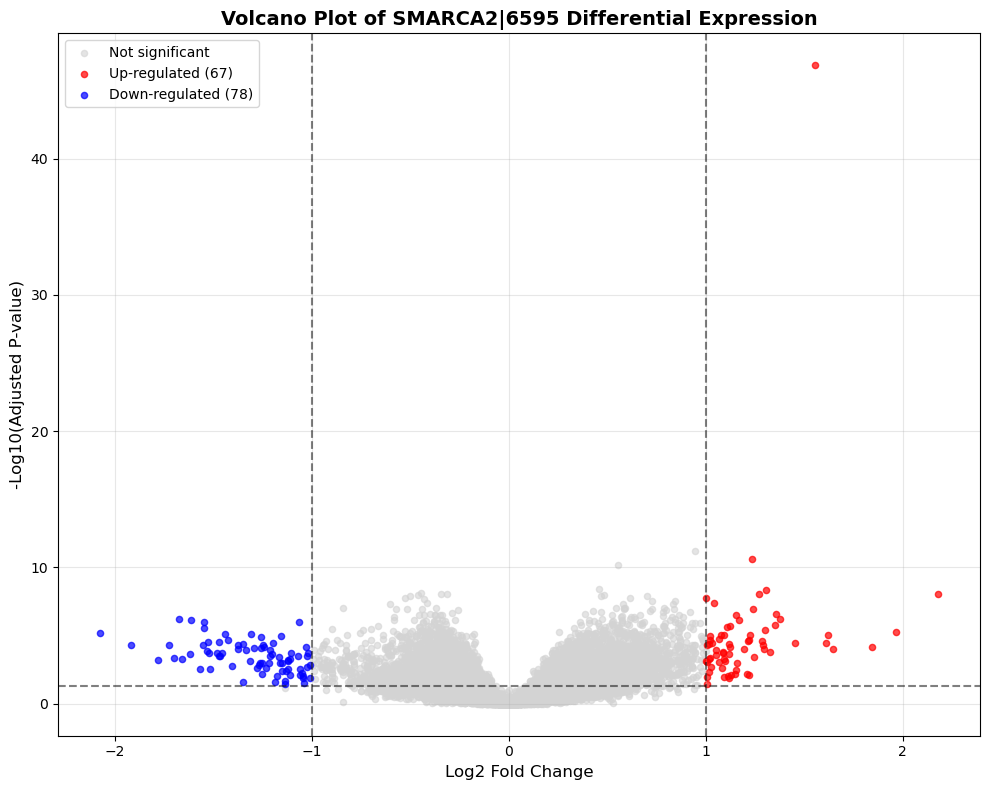

   ✅ Volcano plot saved: figures/volcano_plot.png
📊 Creating expression distribution plots...


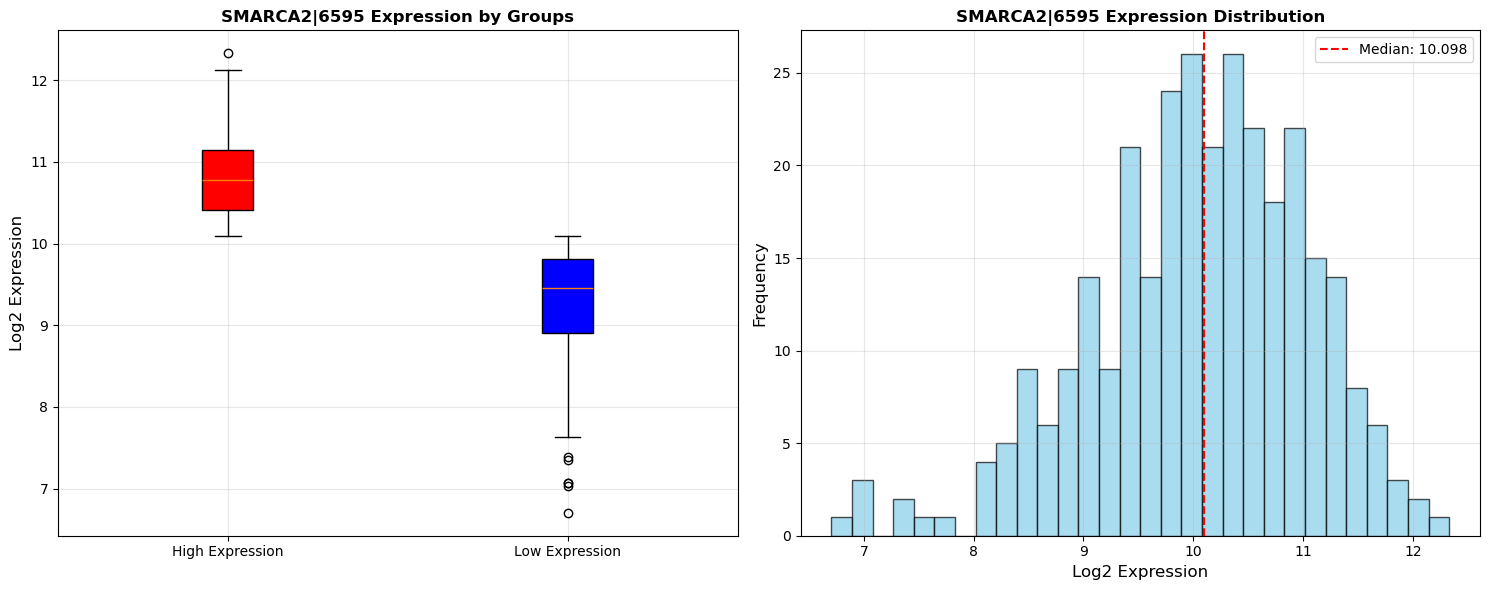

   ✅ Expression distribution plots saved: figures/expression_distribution.png
🔥 Creating correlation heatmap...


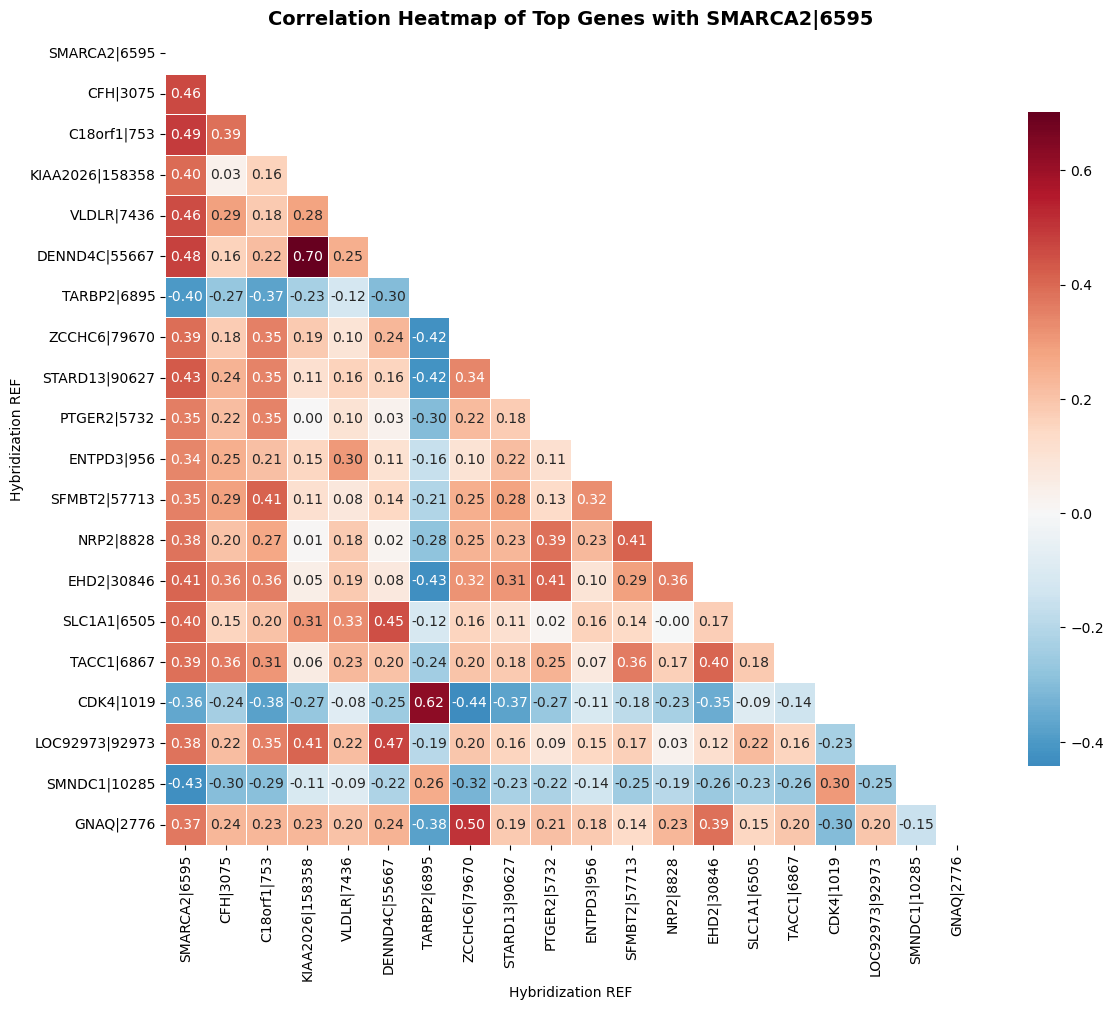

   ✅ Correlation heatmap saved: figures/correlation_heatmap.png
📊 Creating summary plots...


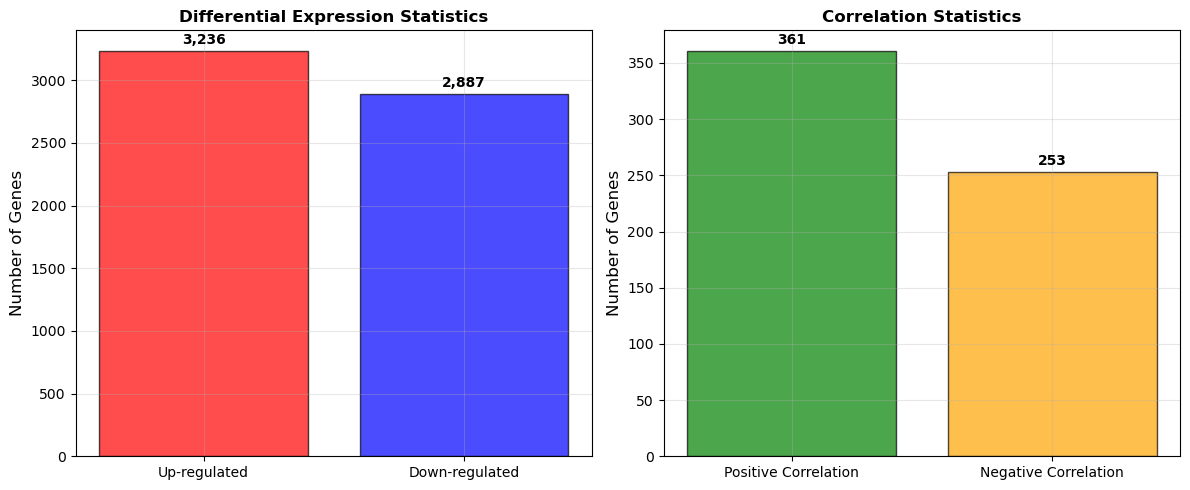

   ✅ Summary plots saved: figures/summary_barplot.png
🎉 All visualizations completed!


In [15]:
def create_volcano_plot(deg_results, save_path="volcano_plot.png"):
    """
    Create volcano plot
    """
    
    print("🌋 Creating volcano plot...")
    
    # Prepare data
    log2fc = deg_results['log2FC']
    neglog10p = -np.log10(deg_results['padj'] + 1e-300)  # Avoid log(0)
    
    # Set significance and fold change thresholds
    fc_threshold = 1.0
    p_threshold = 0.05
    
    # Classify genes
    significant_up = (deg_results['padj'] < p_threshold) & (deg_results['log2FC'] > fc_threshold)
    significant_down = (deg_results['padj'] < p_threshold) & (deg_results['log2FC'] < -fc_threshold)
    not_significant = ~(significant_up | significant_down)
    
    # Create figure
    plt.figure(figsize=(10, 8))
    
    # Plot scatter points
    plt.scatter(log2fc[not_significant], neglog10p[not_significant], 
               c='lightgray', alpha=0.6, s=20, label='Not significant')
    plt.scatter(log2fc[significant_up], neglog10p[significant_up], 
               c='red', alpha=0.7, s=20, label=f'Up-regulated ({sum(significant_up)})')
    plt.scatter(log2fc[significant_down], neglog10p[significant_down], 
               c='blue', alpha=0.7, s=20, label=f'Down-regulated ({sum(significant_down)})')
    
    # Add threshold lines
    plt.axhline(y=-np.log10(p_threshold), color='black', linestyle='--', alpha=0.5)
    plt.axvline(x=fc_threshold, color='black', linestyle='--', alpha=0.5)
    plt.axvline(x=-fc_threshold, color='black', linestyle='--', alpha=0.5)
    
    # Set labels and title
    plt.xlabel('Log2 Fold Change', fontsize=12)
    plt.ylabel('-Log10(Adjusted P-value)', fontsize=12)
    plt.title(f'Volcano Plot of {brm_gene} Differential Expression', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Save figure
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"   ✅ Volcano plot saved: {save_path}")

def create_expression_distribution(expr, target_gene, groups, save_path="expression_distribution.png"):
    """
    Create expression distribution plots
    """
    
    print("📊 Creating expression distribution plots...")
    
    # Get log2 transformed expression values
    target_expr_log2 = np.log2(expr.loc[target_gene] + 1)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Subplot 1: Boxplot by groups
    high_expr = target_expr_log2[groups == "High"]
    low_expr = target_expr_log2[groups == "Low"]
    
    data_for_box = [high_expr, low_expr]
    labels = ['High Expression', 'Low Expression']
    
    bp = ax1.boxplot(data_for_box, labels=labels, patch_artist=True)
    bp['boxes'][0].set_facecolor('red')
    bp['boxes'][1].set_facecolor('blue')
    
    ax1.set_ylabel('Log2 Expression', fontsize=12)
    ax1.set_title(f'{target_gene} Expression by Groups', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Subplot 2: Overall distribution histogram
    ax2.hist(target_expr_log2, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.axvline(target_expr_log2.median(), color='red', linestyle='--', 
                label=f'Median: {target_expr_log2.median():.3f}')
    ax2.set_xlabel('Log2 Expression', fontsize=12)
    ax2.set_ylabel('Frequency', fontsize=12)
    ax2.set_title(f'{target_gene} Expression Distribution', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"   ✅ Expression distribution plots saved: {save_path}")

def create_correlation_heatmap(expr, significant_corr, target_gene, save_path="correlation_heatmap.png"):
    """
    Create correlation heatmap
    """
    
    print("🔥 Creating correlation heatmap...")
    
    # Select top correlated genes
    top_corr_genes = significant_corr.head(20)['gene'].tolist()
    
    # Ensure target gene is in the list
    if target_gene not in top_corr_genes:
        top_corr_genes = [target_gene] + top_corr_genes[:19]
    
    # Calculate correlation matrix
    corr_matrix = expr.loc[top_corr_genes].T.corr()
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    
    # Create heatmap using seaborn
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Show only lower triangle
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f')
    
    plt.title(f'Correlation Heatmap of Top Genes with {target_gene}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"   ✅ Correlation heatmap saved: {save_path}")

def create_summary_barplot(significant_degs, significant_corr, save_path="summary_barplot.png"):
    """
    Create summary bar plots
    """
    
    print("📊 Creating summary plots...")
    
    # Prepare data
    deg_up = sum(significant_degs['log2FC'] > 0)
    deg_down = sum(significant_degs['log2FC'] < 0)
    corr_pos = sum(significant_corr['rho'] > 0)
    corr_neg = sum(significant_corr['rho'] < 0)
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # DEG statistics
    categories1 = ['Up-regulated', 'Down-regulated']
    values1 = [deg_up, deg_down]
    colors1 = ['red', 'blue']
    
    bars1 = ax1.bar(categories1, values1, color=colors1, alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Number of Genes', fontsize=12)
    ax1.set_title('Differential Expression Statistics', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars1, values1):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values1)*0.01,
                f'{value:,}', ha='center', va='bottom', fontweight='bold')
    
    # Correlation statistics
    categories2 = ['Positive Correlation', 'Negative Correlation']
    values2 = [corr_pos, corr_neg]
    colors2 = ['green', 'orange']
    
    bars2 = ax2.bar(categories2, values2, color=colors2, alpha=0.7, edgecolor='black')
    ax2.set_ylabel('Number of Genes', fontsize=12)
    ax2.set_title('Correlation Statistics', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars2, values2):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(values2)*0.01,
                f'{value:,}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"   ✅ Summary plots saved: {save_path}")

# Create figures output directory
import os
os.makedirs('figures', exist_ok=True)

print("🎨 Starting visualization...")
print("="*50)

# Generate all plots
create_volcano_plot(deg_results, "figures/volcano_plot.png")
create_expression_distribution(expr_filtered, brm_gene, groups, "figures/expression_distribution.png")
create_correlation_heatmap(expr_filtered, significant_corr, brm_gene, "figures/correlation_heatmap.png")
create_summary_barplot(significant_degs, significant_corr, "figures/summary_barplot.png")

print("="*50)
print("🎉 All visualizations completed!")
